# Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales 

## Experimentos con diferentes medidas de las imágenes

El objetivo de este apartado es entrenar la red neuronal utilizando diferentes medidas de imágenes para comprobar si el tamaño de estas afecta al resultado.





In [1]:
#librerias necesarias:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import skimage
import cv2 


## Lectura

In [37]:
def unzipImages(folder='images'):
    with ZipFile('data/2dFootwear/Part1.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part2.zip', 'r') as zipObj:
      zipObj.extractall(folder)
    with ZipFile('data/2dFootwear/Part3.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part4.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part5.zip', 'r') as zipObj:
      zipObj.extractall(folder)

In [61]:
if not os.path.isdir("images_fullsize"):
    unzipImages("images_fullsize")

In [62]:
df = pd.read_csv('data/2dFootwear/Data-information.csv', delimiter=';')
df['Brand'] = df['Brand'].str.strip() #eliminar espacios en blanco

X_files = df['ID'].values.tolist()
brands = df['Brand'].values.tolist()
values_brand, counts_brand = np.unique(brands, return_counts=True)
num_classes = len(values_brand) #se guarda porque será necesario para crear el modelo



In [63]:

def filterMinSamples(data, minSamples, deleteNone=True):
    if deleteNone == True:
        data=data[data['x']!="None"] #eliminar marca = "None"
    dataone=data[data['y']<minSamples] #marcas con pocas muestras
    data=data[data['y']>=minSamples] #marcas con minimo "minSamples" muestras
    num_classes=len(data)
    print('Brands with at least '+str(minSamples)+' samples: %d' %num_classes) 
    print('Brands with only 1 register: %d' %len(dataone)) 
    return data, dataone

dfbrandall = pd.DataFrame({'x':values_brand, 'y':counts_brand}) 

dfbrand, dfbrandone = filterMinSamples(dfbrandall, 5)

num_classes=len(dfbrand)
dfbrand = dfbrand.sort_values('y', ascending = False) #ordenar descendientemente




Brands with at least 5 samples: 7
Brands with only 1 register: 52


In [64]:
def crop_jpeg(crop_size, imgPath):
    dir_list = os.listdir("./"+imgPath)
    for f in dir_list:
        im = Image.open("./"+imgPath+"/"+f)
        h,w,c = im.shape
        im3 = im2.crop((crop_size,crop_size,h-(crop_size*2),w-(crop_size*2))) #Quitar marco medidor

def get_images_full_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    w, h = im.size
    im.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    img = im.crop((150,150,w-150,h-150)) #Quitar marco medidor
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result


def get_images_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im2=im.resize((400,912))
    im3 = im2.crop((40,40,320,872)) #Quitar marco medidor
    im3.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result

def get_images(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []
  for f in dir_list:  
    result.append(f)


  print('Nº files:',len(result))
  return result

In [65]:
shoeFilesFull = get_images_full_to_jpeg("images_fullsize") #execute first time only

Nº files: 1500


### Visualización de imágenes

Se ha creado la función *plot_image* que permite la visualización de las imágenes de cualquiera de las dos bases de datos.

Parámetros:\
*imgPath*: carpeta donde estan las imágenes \
*fileNames*: array con los nombres de los ficheros a mostrar

In [50]:

import skimage
def plot_image(imgPath, fileNames):
  for i in range(len(fileNames)):
    filename = fileNames[i]
    img = skimage.io.imread(imgPath+filename)
   
    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)
  print(fileNames)
  plt.show()

def plot_image2(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)

    plt.show()
def plot_image_grey(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img, cmap='gray')

    plt.show()

In [51]:
def filesWithBrand(shoeFiles):
  files = []
  brands = []
  for image in shoeFiles:
    files.append(image) #filename
    person = df[df['ID'].str[:6]==image[:6]]  #persona+contador de calzado
    brands.append(person['Brand'].iloc[0])

  return pd.DataFrame({'X':files, 'y':brands}) 

def filterBrands(data, one, deleteNone=True):
    #dfbrandone creado antes con las marcas que no cumplen.
    df_shoe_brand=data[~data['y'].isin(one['x'].to_numpy())]
    
    if deleteNone == True:
        df_shoe_brand=df_shoe_brand[df_shoe_brand['y']!="None"]
    
    
    df_shoe_brand['factor_brand'] = pd.Categorical(pd.factorize(df_shoe_brand['y'])[0].astype(np.float32))
    
    return df_shoe_brand

df_shoe_brand_all = filesWithBrand(shoeFilesFull) #contiene todas las muestras

#eliminar aquellas marcas que no aparecen mínimo en "minSample" muestras 
df_shoe_brand = filterBrands(df_shoe_brand_all,dfbrandone)
#número de marcas con 5 o más muestras:
print('Nº of brands: %d' %num_classes)
show_brands = df_shoe_brand.drop_duplicates(subset = "y")
show_brands = show_brands[['y','factor_brand']]
show_brands

Nº of brands: 7


,y,factor_brand
2,Nike,0.0
3,Adidas,1.0
4,Converse,2.0
14,Sperry,3.0
16,Saucony,4.0
20,Asics,5.0
36,Skechers,6.0


In [52]:
def checkBalancedSample(train, test, val):
    checkTest = False
    checkVal = False
    
    #Comprobar si existen en train
    test_in = test.y.isin(train.y).astype(int)
    val_in=val.y.isin(train.y).astype(int)

    #Comprobar que existen todos (todo 1)  
    if all(x==1 for x in test_in):
        checkTest = True
    if all(x==1 for x in val_in):
        checkVal = True
    #Devuelve True si en test y val aparecen marcas que existen en train:
    if checkTest and checkVal:
        return True
    return False

In [53]:
from sklearn.model_selection import train_test_split
def  split_datafiles(df):
  X_train, X_test = train_test_split(df, test_size=0.2 , random_state=random.randint(0,32),shuffle=True)

  X_train, X_val = train_test_split(X_train, test_size=0.14, random_state=random.randint(0,32),shuffle=True) # 0.14 x 0.7 = 0.1
  return X_train,  X_test ,X_val

#Dividir conjunto de datos:
#shoes_train, shoes_test, shoes_val = split_datafiles(df)
shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)

while checkBalancedSample(shoes_train, shoes_test, shoes_val) == False:
    shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)

In [54]:
from skimage import io
img = io.imread("images_fullsize/"+shoeFilesFull[0])

full_w, full_h, full_c = img.shape

FileNotFoundError: No such file: '/Users/laura/Dropbox/UOC/Q3/tfm/proyecto/project/images_fullsize/008_02_L_05.jpeg'

In [24]:
!pip install opencv-contrib-python==4.4.0.44 


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Entrenar el modelo con los datos en train


In [25]:
#Se ha creado un generador para añadir la aumentación de las imágenes
import torchvision.io
import torch
from tensorflow.keras.utils import Sequence
import torchvision.transforms as T
from torchvision.transforms import Resize
from skimage.io import imread
from skimage.util import img_as_float,random_noise
from skimage.transform import rotate
from skimage.color import rgb2gray
import numpy as np
import random
import os

from skimage import transform, util
import cv2  as cv



#función que elimina las filas y columnas en blanco:
def crop_image(gray, pixel_value=220):
    #gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    crop_rows = gray[~np.all(gray > pixel_value, axis=1), :]
    cropped_image = crop_rows[:, ~np.all(crop_rows > pixel_value, axis=0)]
    return cropped_image

def create_variation(theImage,doFlip,doNoise,doRotate):
  image = img_as_float(theImage)
  if doFlip==True:
    image = np.fliplr(image)
  if doNoise==True:
    image = util.random_noise(image)
  if doRotate==True:
    image = transform.rotate(image, random.randint(-45, 45),mode='symmetric')
  return image

class DataGenerator2dFootwear(Sequence):
    # Constructor. Input parameters are:
    # * fileNames   : List of sample file names
    # * doRandomize : If True, the provided file names are shuffled after each training epoch
    #                 and each image can be left unchanged, flipped, corrupted with
    #                 noise or rotated. 8 possible combinations is chosen randomly with equal probability.
    #                 If False, file names are not shuffled and each image is provided unchanged.
    # * imgPath     : Path to the images 
    # * batchSize   : Number of sample images and ground truth items in each batch
    def __init__(self,data, df_shoe_brand,doRandomize=False,imgPath='images', doGray=True,doBin=True, doCrop = True,batchSize=10):
        # Store parameters
        self.imgPath=imgPath
        self.fileNames=data.copy()
        self.batchSize=batchSize
        self.doRandomize=doRandomize
        self.df_shoe_brand=df_shoe_brand
        self.doGray=doGray
        self.doBin=doBin
        self.doCrop=doCrop
        # Get number of files (to avoid computing them later)
        self.numImages=len(data)
        # Shuffle them if required
        self.on_epoch_end()

    # Shuffle data if required
    def on_epoch_end(self):
        if self.doRandomize:
            random.shuffle(self.fileNames)

    # Returns the number of total batches
    def __len__(self):
        return int(np.ceil(float(self.numImages)/float(self.batchSize)))

    
    # Input  : theIndex - Index of the image to load within self.fileNames.
    # Output : theImage - Loaded (and possibly transformed) image. Must be
    #                     of float type with values within [0,1]
    #          theClass - Shoe brand
    def _load_image_(self,theIndex):

   
        file = self.fileNames[theIndex]  
        
        
        img = io.imread(self.imgPath+file)
        h,w,c = img.shape #guardar el shape por si se hace crop poder hacer el resize 
        if self.doGray:#escala de grises
            img = rgb2gray(img)
            #plot_image_grey(img)
        if self.doBin: #blanco y negro
            test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
        if self.doCrop: #quitar columnas/filas blancas
            img = crop_image(img)
        #plot_image_grey(newimg)
            img = cv2.resize(img, (h,w), interpolation = cv2.INTER_AREA)
        
        theImage = img_as_float(img) 
        
        theImage=theImage /255.0 #normalizar (quito rescaling del modelo)

        #añadir aumentación a las imágenes:
        if self.doRandomize:
          theImage=create_variation(img,random.choice([True, False]),random.choice([True, False]),random.choice([True, False])) 
        #else:
         # theImage=create_variation(img,False, False, False)

        #Buscar la imagen en el csv para extraer la Marca:
        person = self.df_shoe_brand[self.df_shoe_brand['X'].str[:6]==file[:6]]  #persona+contador de calzado
        theClass = person['factor_brand'].iloc[0]#self.classes[theIndex] #¿debe ser numérico o podría ser la etiqueta?
        return theImage,theClass

    # Provides the images,class batch
    # Batch format:
    # - X : The data. Numpy array of shape (bs,nr,nc,3)
    # - y : The ground truth. Numpy array of shape (bs,1)
    # Where nb=batch size, nr=num rows, nc=num cols
    def __getitem__(self,theIndex):
        X=[]
        y=[]
        bStart=max(theIndex*self.batchSize,0)
        bEnd=min((theIndex+1)*self.batchSize,self.numImages)
        for i in range(bStart,bEnd):
            [curImage,curGT]=self._load_image_(i)
            X.append(curImage)
            y.append(curGT)
        return np.array(X),np.array(y)
    
    


In [26]:
#Modelo con dropout:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Softmax, Rescaling, Dropout
import tensorflow as tf
def createModelTest(color, w, h):
    if color == True:
        shape = (w,h,3)
    else:
        shape = (w,h,1)
    model_test = models.Sequential([
      #Rescaling(1./255, input_shape=(280,832,3)),
      Conv2D(16, 3, padding='same', activation='relu', input_shape=shape),
      MaxPooling2D(),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax'),
      Flatten()
      #Dense(num_classes,activation='softmax')
      # ,Flatten()
    ])
    return model_test

In [27]:

def plot_history(history):
# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_history_2(history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [28]:
def showResult(predicted, test, array):
    filename = test['X']
    img = skimage.io.imread("images/"+filename)
   
    plt.figure()
    plt.title(test['y']+" "+str(test['factor_brand']))
    plt.imshow(img)
    if array == True:
        print(predicted)
        sort_index = np.argsort(-predicted)
        print(sort_index)
    else:
        print(predicted)

In [35]:
def fitModelCross(aumentation, gray, binary, crop, epoch, w, h):
   
    modelTest = createModelTest(not gray,w,h)
    
    modelTest.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    
    #Configurar el preprocesado que se hará en las imágenes desntro del Generator.
    trainGenerator=DataGenerator2dFootwear(shoes_train['X'].tolist(),df_shoe_brand,aumentation, "images_fullsize/", gray, binary, crop)
    testGenerator=DataGenerator2dFootwear(shoes_test['X'].tolist(),df_shoe_brand,aumentation, "images_fullsize/", gray, binary, crop)
    valGenerator=DataGenerator2dFootwear(shoes_val['X'].tolist(),df_shoe_brand,aumentation, "images_fullsize/", gray, binary, crop)
    print(" ")
    print('Training model with aumentation:'+str(aumentation)+', gray:'+str(gray)+', binary:'+str(binary)+', crop:'+str(crop)+' and epochs = '+str(epoch))
    trainHistory = modelTest.fit(trainGenerator,validation_data=valGenerator, epochs=epoch)
    
    
    return trainHistory, modelTest
    
    

In [36]:
history, model = fitModelCross(False, True, True, True, 10, full_w, full_h)

 
Training model with aumentation:False, gray:True, binary:True, crop:True and epochs = 10


<ipython-input-25-051fa7567717>:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X),np.array(y)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [ ]:
plot_history_2(history)
    
    

In [39]:
#cargar imágenes del otro conjunto de datos

df_fid300 = pd.read_csv('data/FID300/label_table.csv', delimiter=',')

fid300ref = get_images("fid300/references")
fid300crop = get_images("fid300/tracks_cropped")

print(len(df_fid300)) #lineas en el csv
print(fid300ref[0])

X_files = df_fid300['X'].values.tolist()
y = df_fid300['y'].values.tolist()

values_y, counts_y = np.unique(y, return_counts=True)

print('Nº of references: %d' %len(values_y))

dfref = pd.DataFrame({'x':values_y, 'y':counts_y}) 
dfref = dfref.sort_values('y', ascending = False) 
dfref.head(10) # coger los 5 primeros

Nº files: 1175
Nº files: 300
300
00481.png
Nº of references: 130


,x,y
32,37,7
19,22,6
2,3,6
4,5,6
44,49,6
12,14,6
89,1055,6
79,1041,5
55,60,5
9,11,5


In [40]:
from tensorflow.keras.preprocessing.image import  load_img, img_to_array
import cv2


def predict_image(image_dir, model, doGray, doBin, doCrop):
    #print(image_dir)
    raw_img = cv2.imread(image_dir)
    img = cv2.imread(image_dir)

    #img = io.imread(image_dir)
    #h,w = img.shape #guardar el shape por si se hace crop poder hacer el resize 
    if doGray:#escala de grises
        #img = rgb2gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if doBin: #blanco y negro
        test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
    if doCrop: #quitar columnas/filas blancas
        img = crop_image(img)
    img = cv2.resize(img, (832,280), interpolation = cv2.INTER_AREA)
    img = img_as_float(img) 
    img=img /255.0
    img = np.expand_dims(img, axis=0)
    #print(img.shape)
    #raw_image = load_img(image_dir, target_size=(832,280), color_mode = "grayscale")
    #image = img_to_array(raw_image)
    #image = np.expand_dims(image, axis=0)
    #image = image / 255.0
    pred = model.predict(img)
  
    return raw_img, pred

1/1 [==============================] - 0s 48ms/step


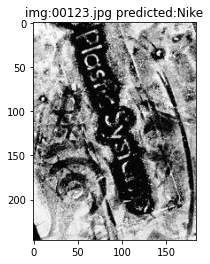

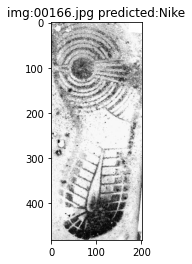

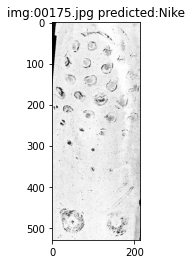

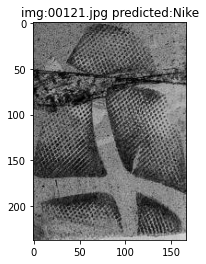

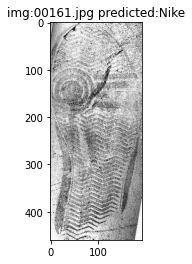

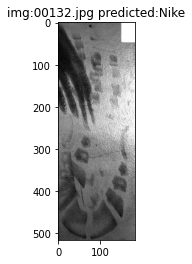

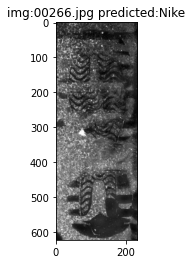

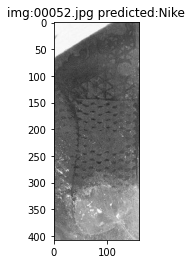

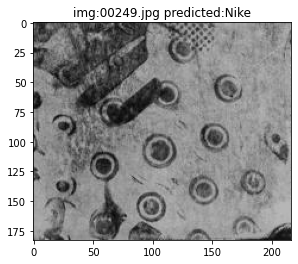

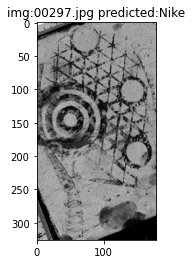

In [41]:
#Se escogen 10 imágenes random.
random_sample = random.choices(fid300crop, k=10)


#fig, axes = plt.subplots(5,2, figsize=(30,30))

for i in random_sample:
    img, pred = predict_image("fid300/tracks_cropped/"+i, model, True, True, False)
    sort_index = np.argsort(-pred)
    #print(sort_index)
    brand= show_brands[show_brands['factor_brand'] == sort_index[0][0]]['y'].iloc[0]
    plt.figure()
    plt.title('img:'+i+" predicted:"+brand)
    plt.imshow(img)



In [ ]:

for i,ax in zip(random_sample, axes.ravel()):
    img, pred = predict_image("fid300/tracks_cropped/"+i, model, True, True, False)
    # Show original image
    #print(pred)
    sort_index = np.argsort(-pred)
    #print(sort_index)
    brand= show_brands[show_brands['factor_brand'] == sort_index[0][0]]['y'].iloc[0]
    #print(brand)
    ax.imshow(img)
    ax.set_title('img:'+i+" predicted:"+brand)

Al utilizar imágenes de otro conjunto de datos, que además estan tomadas con otras técnicas, se observa (mediante análisi qualitativo visual) que no parece acertar la marca. Seguramente esto se debe porque el modelo es demasiado especializado en el tipo de datos.

A continuación 

In [46]:
history_a, model_a = fitModelCross(True, True, True, True, 20)

 
Training model with aumentation:True, gray:True, binary:True, crop:True and epochs = 20
Epoch 1/20
77/77 [==============================] - 81s 1s/step - loss: 13.9240 - accuracy: 0.1247
Epoch 2/20
77/77 [==============================] - 78s 1s/step - loss: 13.6062 - accuracy: 0.1558
Epoch 3/20
77/77 [==============================] - 81s 1s/step - loss: 13.5853 - accuracy: 0.1571
Epoch 4/20
77/77 [==============================] - 92s 1s/step - loss: 13.6062 - accuracy: 0.1558
Epoch 5/20
77/77 [==============================] - 86s 1s/step - loss: 13.6062 - accuracy: 0.1558
Epoch 6/20
77/77 [==============================] - 84s 1s/step - loss: 13.6062 - accuracy: 0.1558
Epoch 7/20
77/77 [==============================] - 85s 1s/step - loss: 13.6062 - accuracy: 0.1558
Epoch 8/20
77/77 [==============================] - 84s 1s/step - loss: 13.5853 - accuracy: 0.1571
Epoch 9/20
77/77 [==============================] - 85s 1s/step - loss: 13.6062 - accuracy: 0.1558
Epoch 10/20
77/77 [

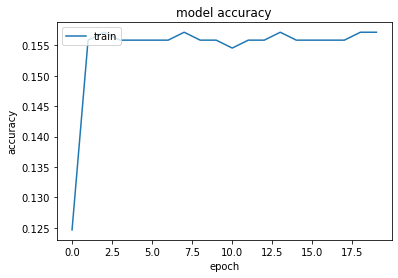

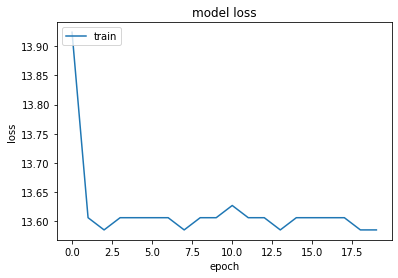

In [47]:
plot_history_2(history_a)

1/1 [==============================] - 0s 53ms/step


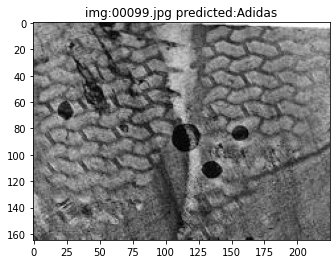

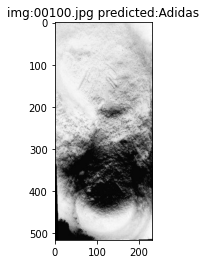

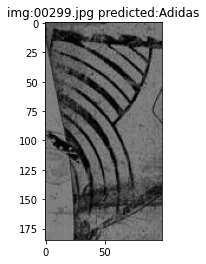

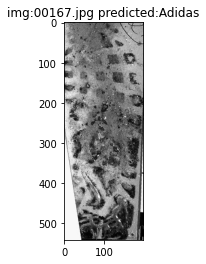

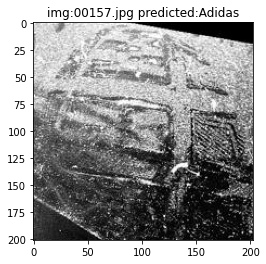

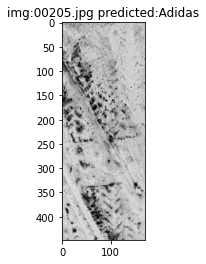

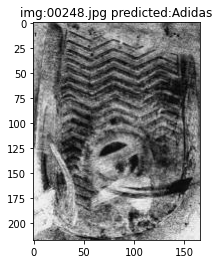

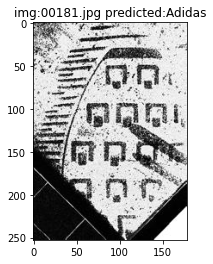

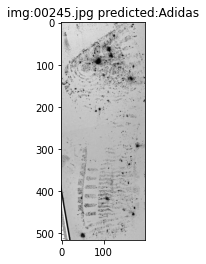

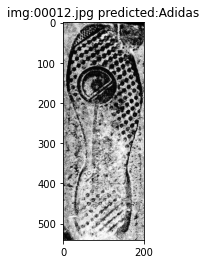

In [48]:
random_sample = random.choices(fid300crop, k=10)


#fig, axes = plt.subplots(5,2, figsize=(30,30))

for i in random_sample:
    img, pred = predict_image("fid300/tracks_cropped/"+i, model_a, True, True, False)
    sort_index = np.argsort(-pred)
    #print(sort_index)
    brand= show_brands[show_brands['factor_brand'] == sort_index[0][0]]['y'].iloc[0]
    plt.figure()
    plt.title('img:'+i+" predicted:"+brand)
    plt.imshow(img)
